## 2023-06-25: Markov Chain Monte Carlo (MCMC) – Impact of Neglecting Asymmetry of Transition Probabilities

*Last Updated*: 2023-06-25

### Authors
* Kevin Chu (kevin@velexi.com)


### Overview
This Jupyter notebook demonstrates the impact of neglecting asymmetry of the transition probability when estimating a uniform distribution on an interval.

### Methods
We run MCMC simulations using acceptance probabilities with and without the ratio of the backward and forward transition probabilities.

#### Experimental Setup

* Probability distribution to estimate: uniform distribution on an interval
  $[a, b]$.

* Transition probability density:

  $$
  p(x' | x)
  = \left\{\begin{array}{ll}
      (1 - p_{focus})\left(\frac{1}{W}\right)
      & \textrm{if $|x - x'| < \frac{\Delta}{2}$} \\
      (1 - p_{focus})\left(\frac{1}{W}\right) + p_{focus}\left(\frac{1}{\Delta}\right)
      &\textrm{if $|x - x'| \ge \frac{\Delta}{2}$}
    \end{array}\right.
  $$
  
  where $W = (b - a)$ is the width of the interval, $p_{focus}$ is the probability that the next value is focused around the current value, and $\Delta$ is the width of the region around the current value that the next value is uniformly drawn from when the next value is focused around the current value.

#### Analysis Methods

The following methods are used to compare the estimated PDF is compared against the expected PDF:

* the Anderson-Darling and Kolmogorov-Smirnov tests; and

* visual inspection of the estimated and expected PDFs.

### Results

* For the the type of transition probability density used to generate MCMC values, neglecting the transition probability ratio in the acceptance probability leads to

    - lower than expected sampling at the ends of the intervals and

    - greater than expected sampling about $\Delta/2$ away from the ends of the intervals.
    
  The estimated PDF is slightly raised interior of the interval but close to the expected PDF value.
  
* When the transition probability ratio is included in the acceptance probability, the Anderson-Darling and Kolmogorov-Smirnov tests often reject the hypothesis that the estimated PDF is the same as the uniform distribution. However, the test statistics are much closer to 0 when the transition probability ratio is included than when it is neglected.

In [1]:
# --- User Parameters

# ------ Markov Chain Monte Carlo (MCMC) parameters

# Number of samples to use to estimate probability distributions
num_pdf_samples = 10000000;

# Number of samples to use during burn-in phase
num_burn_in_samples = 1000000;

# Transition probability parameters
focus_probability = 0.9;
focus_width_fraction = 0.2;

# --- Probability distribution parameters

# PDF parameters
min_value = 1;
max_value = 5;

# --- Analysis parameters

# number of histogram bins
num_hist_bins = 50;

### Preparations

In [2]:
# --- Imports

import Distributions
using HypothesisTests: pvalue, OneSampleADTest, ExactOneSampleKSTest
using Plots: bar, plot!
using Random: rand
using StatsBase: Histogram, fit, normalize

#### Functions

In [3]:
"""
    run_mcmc_simulation()

Run a Markov Chain Monte Carlo (MCMC) simulation to estimate the uniform distribution
on the interval `[min_value, max_value]`.

Arguments
---------
* get_next_sample: method for generating next sample from the current sample

* min_value: lower bound of interval of uniform distribution

* max_value: upper bound of interval of uniform distribution

* num_pdf_samples: number of samples to use to estimate PDF

* num_burn_in_samples: number of samples to use during burn-in phase

Return values
-------------
samples: samples generated from MCMC simulation
"""
function run_mcmc_simulation(
    get_next_sample::Function,
    min_value::Real, max_value::Real;
    num_pdf_samples::Int=10000000, num_burn_in_samples::Int=1000000
)
    # --- Initialize MCMC

    # Initialize samples
    samples = Vector{Float64}(undef, num_pdf_samples)

    # Initialize current value
    current_value = min_value + (max_value - min_value) * rand()

    # --- Burn-in MCMC

    for i in 1:num_burn_in_samples
        # Get next value
        next_value, acceptance_ratio = get_next_sample(current_value)

        # Update current_value
        if acceptance_ratio > 1 || rand() < acceptance_ratio
            current_value = next_value
        end
    end

    # --- Generate PDF samples

    for i in 1:num_pdf_samples
        # Get next value
        next_value, acceptance_ratio = get_next_sample(current_value)

        # Update current_value
        if acceptance_ratio > 1 || rand() < acceptance_ratio
            current_value = next_value
        end

        # Save sample
        samples[i] = current_value
    end
    
    return samples
end

"""
    plot_estimated_pdf()

Plot estimated PDF compared against PDF of the expected distribution.

Arguments
---------
* samples: samples generated from MCMC simulation

* min_value: lower bound of interval of uniform distribution

* max_value: upper bound of interval of uniform distribution
"""
function plot_estimated_pdf(
    samples::Vector{Float64}, min_value::Real, max_value::Real;
    num_hist_bins::Int=50
)
    # --- Preparations
    
    # Construct expected distribution
    expected_dist = Distributions.Uniform(min_value, max_value)
    
    # Histogram parameters
    hist_bin_edges = range(min_value, max_value; length=num_hist_bins+1)

    # --- Generate histogram

    hist = normalize(fit(Histogram, samples, hist_bin_edges), mode=:pdf)

    # --- Plot histogram

    bar(hist.edges, hist.weights; label="Sample")
    plot!(x -> Distributions.pdf(expected_dist, x); label="Expected", lw=2, color=:black)
end

"""
    perform_statistical_tests()

Perform statistical tests to evaluate how close the PDF it to the expected distribution.

Arguments
---------
* samples: samples generated from MCMC simulation

* min_value: lower bound of interval of uniform distribution

* max_value: upper bound of interval of uniform distribution
"""
function perform_statistical_tests(
    samples::Vector{Float64}, min_value::Real, max_value::Real
)
    # --- Preparations
    
    # Construct expected distribution
    expected_dist = Distributions.Uniform(min_value, max_value)

    # ------ Perform statistical tests
    
    # Anderson-Darling Test
    AD_test = OneSampleADTest(samples, expected_dist)
    AD_p_value = pvalue(AD_test)
    println()
    println("Anderson-Darling Test: $AD_test")
    println("Anderson-Darling p-value: $AD_p_value")

    # Kolmogorov-Smirnov Test
    KS_test = ExactOneSampleKSTest(samples, expected_dist)
    KS_p_value = pvalue(KS_test)
    println()
    println("Kolmogorov-Smirnov Test: $KS_test")
    println("Kolmogorov-Smirnov p-value: $KS_p_value")
end

perform_statistical_tests

### MCMC With Asymmetric Transition Probabilities

In [4]:
"""
    get_next_sample_with_transition_probability_ratio()

Get next MCMC sample and acceptance probability that correctly includes the ratio of
the transition probabilities.

Arguments
---------
* current_value: current value of MCMC sample

* min_value: lower bound of interval of uniform distribution

* max_value: upper bound of interval of uniform distribution

* focus_probability: probability that next sample is focused around the current value

* focus_width_fraction: width of the region around the current value (as a fraction of
    the interval width) when the next sample is focused around the current value
"""
function get_next_sample_with_transition_probability_ratio(
    current_value, min_value, max_value, focus_probability, focus_width_fraction
)
    # --- Preparations

    interval_width = max_value - min_value
    focus_half_width = 0.5 * focus_width_fraction * interval_width

    # --- Generate Markov Chain Monte Carlo (MCMC) proposal

    if rand() < focus_probability
        # Get sample from a uniform distribution in a region around the current value
        focus_min_value = max(current_value - focus_half_width, min_value)
        focus_max_value = min(current_value + focus_half_width, max_value)
        next_value = focus_min_value + (focus_max_value - focus_min_value) * rand()

    else
        # Get sample from a uniform distribution on the range of values
        next_value = min_value + (max_value - min_value) * rand()

    end

    # --- Compute forward and backward transition probabilities

    # Initialize transition probabilities with contribution common to all transitions
    p_forward = p_backward = (1 - focus_probability) / interval_width

    # Add contribution from transitions focused around current value
    if abs(next_value - current_value) < focus_half_width
        if current_value < min_value + focus_half_width
            p_forward += focus_probability / (current_value - min_value + focus_half_width)
        elseif current_value > max_value - focus_half_width
            p_forward += focus_probability / (max_value - current_value + focus_half_width)
        else
            p_forward += 0.5 * focus_probability / focus_half_width
        end

        if next_value < min_value + focus_half_width
            p_backward += focus_probability / (next_value - min_value + focus_half_width)
        elseif next_value > max_value - focus_half_width
            p_backward += focus_probability / (max_value - next_value + focus_half_width)
        else
            p_backward += 0.5 * focus_probability / focus_half_width
        end
    end

    return next_value, (p_backward / p_forward)
end

get_next_sample_with_transition_probability_ratio

In [5]:
# --- Run MCMC simulation

samples = run_mcmc_simulation(
    x -> get_next_sample_with_transition_probability_ratio(
        x, min_value, max_value, focus_probability, focus_width_fraction),
    min_value,
    max_value;
    num_pdf_samples=num_pdf_samples,
    num_burn_in_samples=num_burn_in_samples);

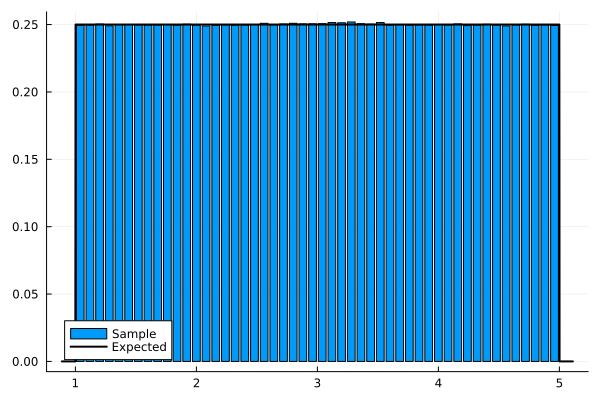

In [6]:
# --- Plot histogram

plot_estimated_pdf(samples, min_value, max_value)

In [7]:
# --- Perform statistical tests

perform_statistical_tests(samples, min_value, max_value)


Anderson-Darling Test: One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           0.0135

Details:
    number of observations:   10000000
    sample mean:              3.000089502072913
    sample SD:                1.154045332955755
    A² statistic:             3.6115969923110947

Anderson-Darling p-value: 0.013529486590617368


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/r322N/src/kolmogorov_smirnov.jl:68



Kolmogorov-Smirnov Test: Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.000494296

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0151

Details:
    number of observations:   10000000

Kolmogorov-Smirnov p-value: 0.015089595952280285


### MCMC Without Asymmetric Transition Probabilities

In [8]:
"""
    get_next_sample_no_transition_probability_ratio()

Get next MCMC sample and acceptance probability that neglects the ratio of the transition
probabilities.

Arguments
---------
* current_value: current value of MCMC sample

* min_value: lower bound of interval of uniform distribution

* max_value: upper bound of interval of uniform distribution

* focus_probability: probability that next sample is focused around the current value

* focus_width_fraction: width of the region around the current value (as a fraction of
    the interval width) when the next sample is focused around the current value
"""
function get_next_sample_no_transition_probability_ratio(
    current_value, min_value, max_value, focus_probability, focus_width_fraction
)
    # --- Preparations

    interval_width = max_value - min_value
    focus_half_width = 0.5 * focus_width_fraction * interval_width

    # --- Generate Markov Chain Monte Carlo (MCMC) proposal

    if rand() < focus_probability
        # Get sample from a uniform distribution in a region around the current value
        focus_min_value = max(current_value - focus_half_width, min_value)
        focus_max_value = min(current_value + focus_half_width, max_value)
        next_value = focus_min_value + (focus_max_value - focus_min_value) * rand()

    else
        # Get sample from a uniform distribution on the range of values
        next_value = min_value + (max_value - min_value) * rand()

    end

    return next_value, 1
end

get_next_sample_no_transition_probability_ratio

In [9]:
# --- Run MCMC simulation

samples = run_mcmc_simulation(
    x -> get_next_sample_no_transition_probability_ratio(
        x, min_value, max_value, focus_probability, focus_width_fraction),
    min_value,
    max_value;
    num_pdf_samples=num_pdf_samples,
    num_burn_in_samples=num_burn_in_samples);

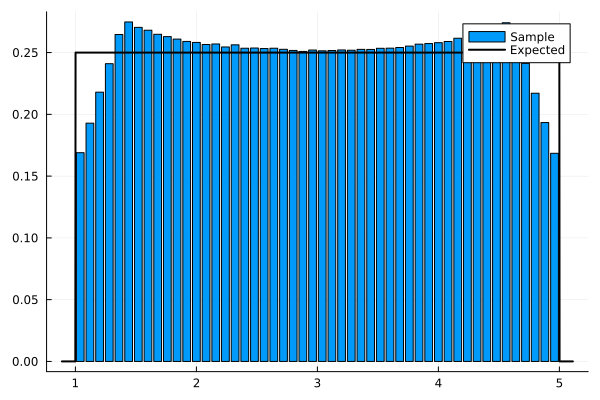

In [10]:
# --- Plot histogram

plot_estimated_pdf(samples, min_value, max_value)

In [11]:
# --- Perform statistical tests

perform_statistical_tests(samples, min_value, max_value)


Anderson-Darling Test: One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-10

Details:
    number of observations:   10000000
    sample mean:              3.0001079747670714
    sample SD:                1.1290191063559007
    A² statistic:             6802.510641758624

Anderson-Darling p-value: 6.000000496442226e-11

Kolmogorov-Smirnov Test: Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0143921

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   10000000

Kolmogorov-Smirnov p-value